# Set up

In [1]:
!git clone https://github.com/aliswh/lastfm
!cd lastfm; pip install -r requirements.txt

Cloning into 'lastfm'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 447 (delta 280), reused 294 (delta 140), pack-reused 0
Receiving objects: 100% (447/447), 3.48 MiB | 11.07 MiB/s, done.
Resolving deltas: 100% (280/280), done.
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 47.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9e0a23c5590306a48b79aff766fa29b5b2e2ffe3614cc20ebb68dd5035b42aee
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
!wget https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
!cp gcs-connector-hadoop3-latest.jar /usr/local/lib/python3.7/dist-packages/pyspark/jars

--2022-03-02 13:22:31--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31607894 (30M) [application/java-archive]
Saving to: ‘gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  30.14M   145MB/s    in 0.2s    

2022-03-02 13:22:32 (145 MB/s) - ‘gcs-connector-hadoop3-latest.jar’ saved [31607894/31607894]



In [3]:
import json
import datetime

import pyspark
from pyspark.sql import SparkSession
from py4j.java_gateway import UserHelpAutoCompletion
from lastfm.src.ingestion_layer.googlestorage import *
from lastfm.src.ingestion_layer.pylastsource import *
from lastfm.src.ingestion_layer.config import *
from lastfm.src.ingestion_layer.batchwriter import *
from lastfm.src.ingestion_layer.pysparkreader import *

# Read data

In [4]:
spark = SparkSession.builder.appName('A4BD Project').getOrCreate()
sc = pyspark.SparkContext.getOrCreate()
reader = PySparkReader(sc)
source = PyLastSource(AUTH_DATA) # for tests

In [5]:
user_sessions_stats = {
    'user_avg_tracks': [],
    'user_avg_session': [],
    'user_avg_session_len' : []
    }

name_path = 'listening_sessions' + '_'
ls_stats_path = 'listening_sessions/listening_sessions_statistics/'

for key,value in user_sessions_stats.items():
  user_sessions_stats[key] = reader.read(ls_stats_path+name_path+key,dir=False).collect()[0]

user_sessions_stats['user_avg_tracks']

[['Frax777', 5.246],
 ['WhiteLegioN', 3.082],
 ['jumd', 3.773],
 ['kurtphyre', 2.22],
 ['stephiesama', 2.931],
 ['abernes', 2.136],
 ['Gunthar666', 6.614],
 ['junjindua', 2.838],
 ['jreisner', 5.259],
 ['23kulpamens', 2.56]]

# Show data

In [6]:
for key in user_sessions_stats.keys():
  user_sessions_stats[key] = {item[0]:item[1] for item in user_sessions_stats[key]}

user_sessions_stats

{'user_avg_session': {'23kulpamens': 114.009,
  'Frax777': 55.018,
  'Gunthar666': 42.023,
  'WhiteLegioN': 95.01,
  'abernes': 138.007,
  'jreisner': 52.019,
  'jumd': 73.013,
  'junjindua': 103.01,
  'kurtphyre': 130.008,
  'stephiesama': 100.01},
 'user_avg_session_len': {'23kulpamens': 347.259,
  'Frax777': 245.421,
  'Gunthar666': 238.705,
  'WhiteLegioN': 220.866,
  'abernes': 234.35,
  'jreisner': 225.426,
  'jumd': 264.173,
  'junjindua': 206.514,
  'kurtphyre': 284.167,
  'stephiesama': 288.794},
 'user_avg_tracks': {'23kulpamens': 2.56,
  'Frax777': 5.246,
  'Gunthar666': 6.614,
  'WhiteLegioN': 3.082,
  'abernes': 2.136,
  'jreisner': 5.259,
  'jumd': 3.773,
  'junjindua': 2.838,
  'kurtphyre': 2.22,
  'stephiesama': 2.931}}

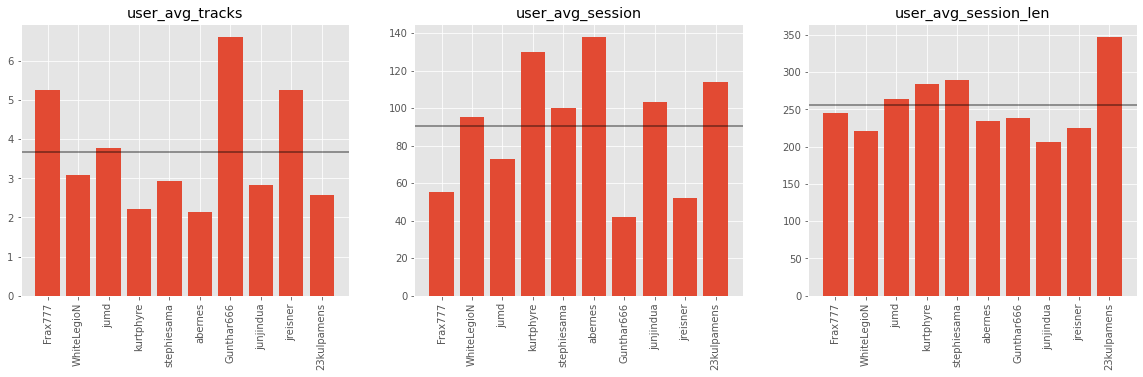

In [7]:
import matplotlib.pylab as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i,key in enumerate(user_sessions_stats.keys()):
  to_plot = user_sessions_stats[key]
  x,y = list(to_plot.keys()), list(to_plot.values())
  avg = sum(y) / len(y)
  ax[i].axhline(avg, xmin=-5, xmax=5, color='black', alpha=0.5)
  ax[i].bar(x,y)
  ax[i].set_xticklabels(x, rotation = 90)
  ax[i].set_title(key, color='black')

#Greatest hits

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
#Setup
all_hits_dict = reader.read('all_greatest_hits').collect()[0]
for date in all_hits_dict:
    all_hits_dict[date] = {(f'{title}\n[{artist}]'):count for title, artist, count in all_hits_dict[date]}
genre_hits_dict = reader.read('genre_greatest_hits').collect()[0]
for date in genre_hits_dict:
  for genre in genre_hits_dict[date]:
    genre_hits_dict[date][genre] = {(f'{title}\n[{artist}]'):count for title, artist, count in genre_hits_dict[date][genre]}

In [54]:
def plotter(to_plot, ax, date, genre=None):
    x = list(to_plot.keys())
    y = list(to_plot.values())
    if len(x) == 1:
      explode = None
    else: explode = [i/sum(y)/3 for i in y]
    ax.pie(y, explode=explode, labels=x, autopct=lambda p: '{:.2f}%  ({:,.0f})'.format(p,p * sum(y)/100))
    title = f'{date} greatest hits'.upper()
    if genre:
      title = title+f'\n[{genre}]'.upper()
    ax.set_title(title, fontweight='bold', pad=25)
    ax.patch.set_edgecolor('black') 
    ax.patch.set_linewidth('1')  


def pretty_print(hits_dict, genres=False):
  x_plot_axe = len(hits_dict.keys())
  if genres:
    y_plot_axe = len(hits_dict['today'].keys())
  else:
    y_plot_axe = 1
  fig, ax = plt.subplots(y_plot_axe,x_plot_axe, figsize=(7*x_plot_axe, 11*y_plot_axe))
  plt.subplots_adjust(bottom=0.2)
  for i,date in enumerate(hits_dict.keys()):
    if genres:
      for j,genre in enumerate(hits_dict[date].keys()):
        to_plot = hits_dict[date][genre]
        plotter(to_plot, ax[j,i], date, genre)
    else:
      to_plot = hits_dict[date]
      plotter(to_plot, ax[i], date) 

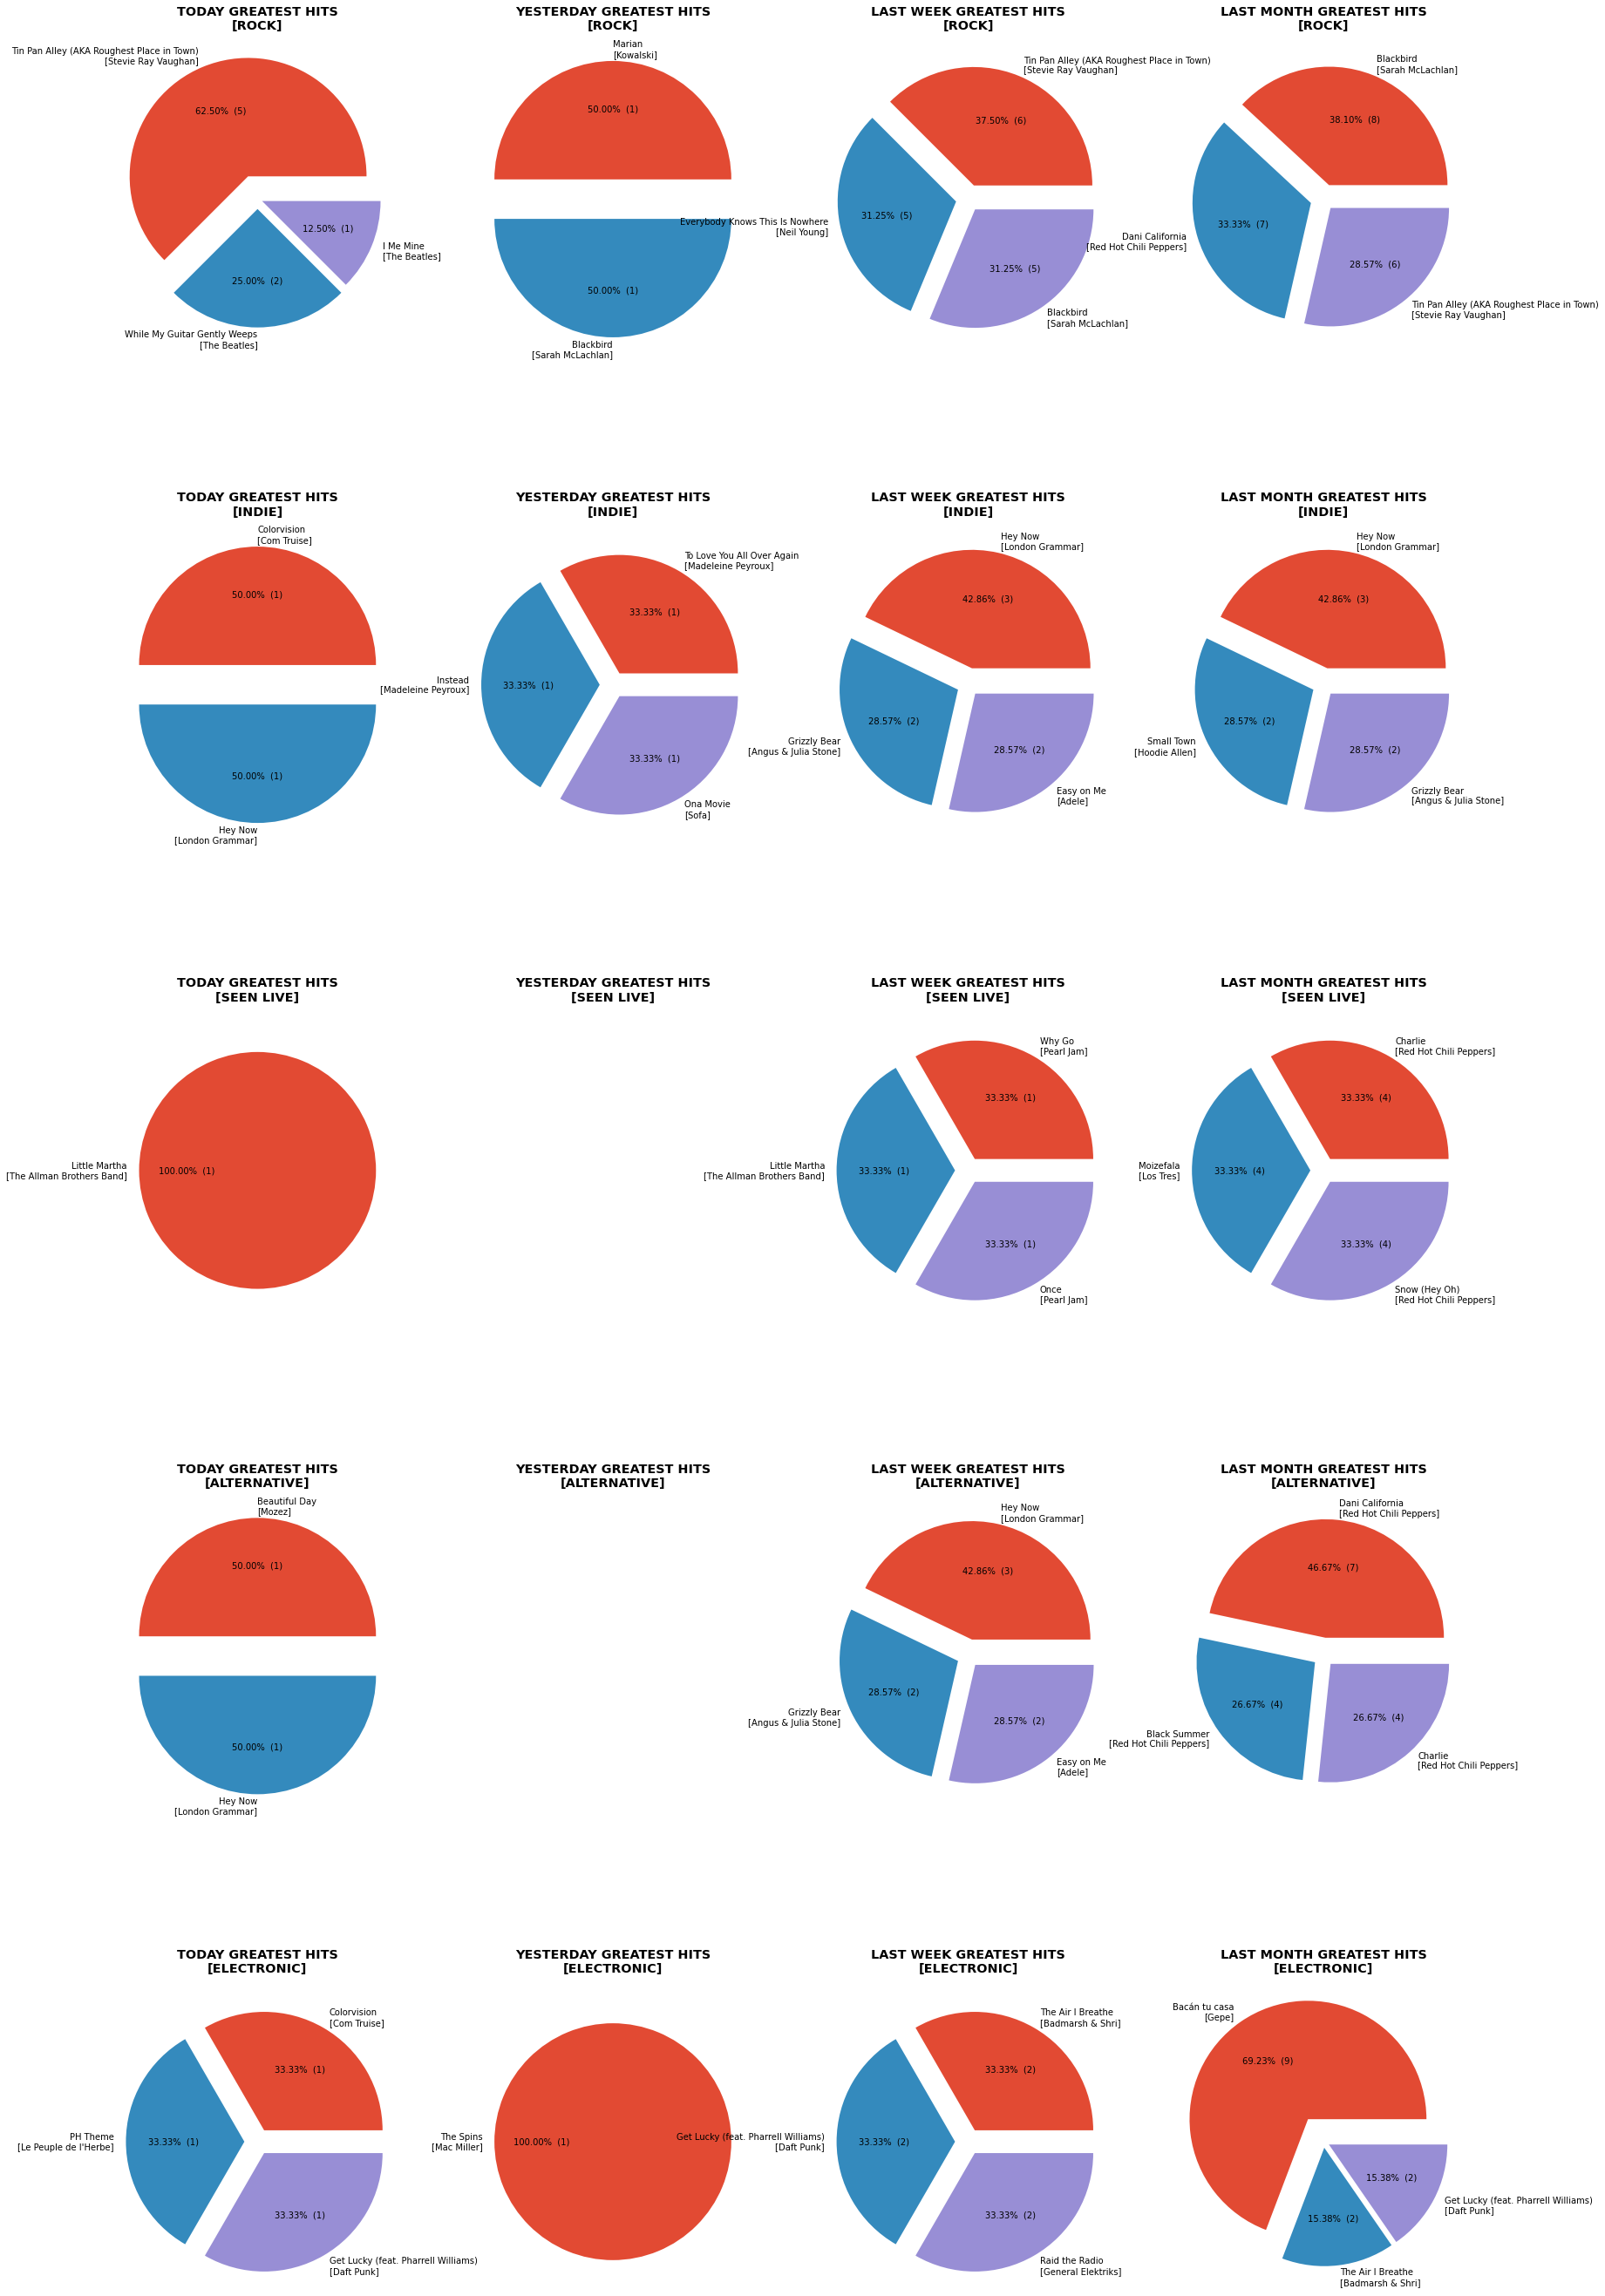

In [52]:
pretty_print(genre_hits_dict, genres=True)

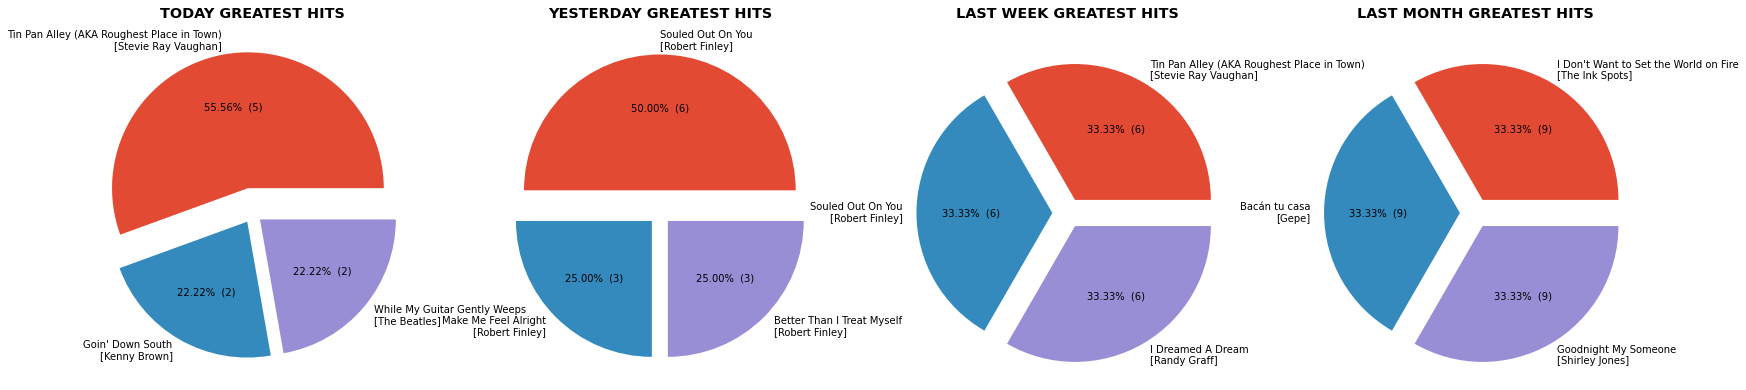

In [55]:
pretty_print(all_hits_dict, genres=False)